# Impact of COVID-19 on NASDAQ earnings

This article studies COVID-19 impact by looking at how company earnings changed in the wake of COVID-19. Specifically it uses machine learning to predict the key factors behind a NASDAQ company's earnings declining by more than 10% YoY in Q2.
This article uses concepts from financial statement analysis and machine learning to derive insights.


Feel free to refer to my medium article https://medium.com/@robinjon/covid-19-impact-on-nasdaq-earnings-through-an-ai-lens-97f13ad60af7 for a less-technical view + more intuitive understanding

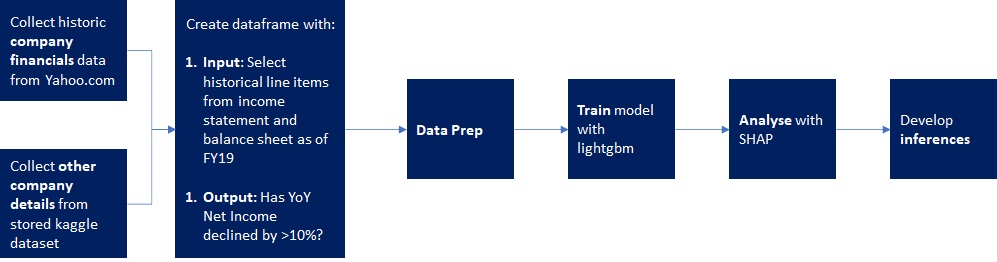

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

!pip install yahooquery
from yahooquery import Ticker
!pip install lightgbm
import matplotlib.pyplot as plt


In [ ]:
ticker_details = pd.read_csv('../input/ticker-details-2/ticker_details (2).csv')#[0]


#nasdaq_list = pd.read_csv('../input/stock-market-dataset/symbols_valid_meta.csv')#[0]
#nasdaq_list.head()
symbols = ticker_details["ticker"].to_list()

Download financials data from yahoo using yahooquery. I snapshotted this in mid-September. I am afraid you may not get the same results now because Yahoo gives data only till about 5 quarters back for non-premium subscription. You may have to modify DataPrep to suit the data you are getting from Yahoo/any other source in case you are running this

In [ ]:
# from yahooquery import Ticker
# all_financial_data = pd.DataFrame()
# all_financial_data_y = pd.DataFrame()
# count = 0


# # Make asynchronous requests
# for each in symbols:
#     count = count + 1
#     print(each, count)
#     faang = Ticker(each,asynchronous=True)
#     all_q = faang.all_financial_data('q')

#     all_a = faang.all_financial_data('a')


#     if (not(type(all_q) == str)):
#         #all_q["symbol"] = each
#         all_financial_data = all_financial_data.append(all_q)

#     if (not(type(all_a) == str)):
#         #all_a["symbol"] = each
#         all_financial_data_y = all_financial_data_y.append(all_a)
    
# all_financial_data.to_csv("all_financial_data.csv")
# all_financial_data_y.to_csv("all_financial_data_y.csv")
# all_financial_data.reset_index(inplace = True)#.head()
# all_financial_data_y.reset_index(inplace = True)

In [ ]:
#Downloaded data from Yahoo. I am not making this public because of potential copyright issues. Suggest you use the above lines to create your own dataframe
all_financial_data = pd.read_csv("../input/all-financial-data/./all_financial_data.csv")
all_financial_data_y = pd.read_csv("../input/all-financial-data/./all_financial_data_y.csv")

**all_financial_data has a lot of data points from Income Statement, Balance Sheet and Cash Flow Statement. I will download everything but select a few fields based on:**
1. My hypothesis of what can be potential predictors
2. Avoiding multi-collinearity (Eg. Having Revenue, COGS and Gross Profit would result in multi-collinearity because one may be inferred from other two)

# Data Prep

In [ ]:
all_financial_data.columns.to_list()

In [ ]:

all_financial_data_filt = all_financial_data[all_financial_data["periodType"] == "3M"]
all_financial_data_filt.sort_values(by = ["symbol", "asOfDate"], inplace = True)

In [ ]:
#Shortlist 3 quarters - FY19Q2 and FY20Q2

all_financial_data_2019_q2 = all_financial_data_filt[all_financial_data_filt["asOfDate"].isin(["2019-06-30", "2019-07-31", "2019-08-31"])]#["symbol"].unique()##.value_counts()
all_financial_data_2020_q2 = all_financial_data_filt[all_financial_data_filt["asOfDate"].isin(["2020-06-30", "2020-07-31", "2020-08-31"])]#["symbol"].unique()##.value_counts()
all_financial_data_2019_q3 = all_financial_data_filt[all_financial_data_filt["asOfDate"].isin(["2019-09-30", "2019-10-31", "2019-11-30"])]#["symbol"].unique()##.value_counts()
all_financial_data_2019_q2.set_index("symbol", inplace = True)
all_financial_data_2020_q2.set_index("symbol", inplace = True)
all_financial_data_2019_q3.set_index("symbol", inplace = True)

In [ ]:
#Retain only common sticker symbols

all_financial_data_2019_q2_t = all_financial_data_2019_q2[~all_financial_data_2019_q2.NetIncome.isna()].merge(right = all_financial_data_2020_q2[~all_financial_data_2020_q2.NetIncome.isna()]["SalariesAndWages"], left_on = "symbol", right_on = "symbol", how = 'inner').drop(columns = ["SalariesAndWages_x", "SalariesAndWages_y"])
all_financial_data_2020_q2_t = all_financial_data_2020_q2[~all_financial_data_2020_q2.NetIncome.isna()].merge(right = all_financial_data_2019_q2[~all_financial_data_2019_q2.NetIncome.isna()]["SalariesAndWages"], left_on = "symbol", right_on = "symbol", how = 'inner').drop(columns = ["SalariesAndWages_x", "SalariesAndWages_y"])

all_financial_data_2019_q2_t.drop_duplicates(inplace = True)
all_financial_data_2020_q2_t.drop_duplicates(inplace = True)


In [ ]:
all_financial_data_filt["asOfDate"].value_counts()

In [ ]:
# Which companies have more than 10% decline in NetIncome?

test_yoy_q = pd.to_numeric(all_financial_data_2020_q2_t.NetIncome) - pd.to_numeric(all_financial_data_2019_q2_t.NetIncome)

output = test_yoy_q/abs(pd.to_numeric(all_financial_data_2019_q2_t.NetIncome))
output_pc = (output<-.1)

percentage = sum(test_yoy_q<0)/len(test_yoy_q)
print('Percentage of companies with negative earnings growth from 2019Q2 to 2020Q2 = {:2.2%}'.format(percentage))

In [ ]:
all_financial_data_2019_q2_t = all_financial_data_2019_q2[~all_financial_data_2019_q2.NetIncome.isna()].merge(right = all_financial_data_2019_q3[~all_financial_data_2019_q3.NetIncome.isna()]["SalariesAndWages"], left_on = "symbol", right_on = "symbol", how = 'inner').drop(columns = ["SalariesAndWages_x", "SalariesAndWages_y"])
all_financial_data_2019_q3_t = all_financial_data_2019_q3[~all_financial_data_2019_q3.NetIncome.isna()].merge(right = all_financial_data_2019_q2[~all_financial_data_2019_q2.NetIncome.isna()]["SalariesAndWages"], left_on = "symbol", right_on = "symbol", how = 'inner').drop(columns = ["SalariesAndWages_x", "SalariesAndWages_y"])

all_financial_data_2019_q2_t.drop_duplicates(inplace = True)
all_financial_data_2019_q3_t.drop_duplicates(inplace = True)

test_qoq = pd.to_numeric(all_financial_data_2019_q3_t.NetIncome) - pd.to_numeric(all_financial_data_2019_q2_t.NetIncome)

percentage = sum(test_qoq<0)/len(test_qoq)
print('Percentage of companies with negative earnings growth from 2019Q2 to 2019Q3 = {:2.2%}'.format(percentage))

In [ ]:
#Filter only yearly values. Harmonize rows so that only common rows are retained

all_financial_data_filt_y = all_financial_data_y[all_financial_data_y["periodType"] == "12M"]
all_financial_data_filt_y.drop_duplicates(inplace = True)
all_financial_data_filt_y.sort_values(by = ["symbol", "asOfDate"], inplace = True)#head()#.columns#['symbol'].value_counts()

all_financial_data_2019_y = all_financial_data_filt_y[pd.to_datetime(all_financial_data_filt_y["asOfDate"]).dt.year == 2019]
all_financial_data_2019_y.set_index("symbol", inplace = True)

all_financial_data_2019_y_t_t = all_financial_data_2019_y[~all_financial_data_2019_y.NetIncome.isna()].merge(right = all_financial_data_2020_q2_t[~all_financial_data_2020_q2_t.NetIncome.isna()]["BasicAverageShares"], left_on = "symbol", right_on = "symbol", how = 'inner').drop(columns = ["BasicAverageShares_x", "BasicAverageShares_y"])



In [ ]:
#Remove zero revenue lines
all_financial_data_2019_y_t_t = all_financial_data_2019_y_t_t[all_financial_data_2019_y_t_t["TotalRevenue"] != 0]

In [ ]:
#Augment with industry sector etc.
ticker_details = ticker_details[ticker_details["country"] == "United States"]
ticker_details.drop(columns = ["country"], inplace = True)

In [ ]:
#Harmonize rows so that only common rows are retained
all_financial_data_2019_y_t = all_financial_data_2019_y_t_t.merge(right = ticker_details, how = 'inner', left_on = "symbol", right_on = "ticker")#.drop(columns = "ticker")
output_pc = output_pc.loc[all_financial_data_2019_y_t.ticker]

In [ ]:
#Feature selection with 2 objectives:
# 1. Include fields with high level of data availability (less NaNs etc.)
# 2. Avoid multi-collinearity - e.g. Gross Profit = Revenue - COGS, so cant pcik three, just pick just two etc. 


all_financial_data_2019_y_t["MarketCapToNetIncome"] = all_financial_data_2019_y_t["MarketCap"]/all_financial_data_2019_y_t["NetIncome"]
all_financial_data_2019_y_t["OpexToRevenue"] = all_financial_data_2019_y_t["OperatingExpense"]/all_financial_data_2019_y_t["TotalRevenue"]
all_financial_data_2019_y_t["EBITToRevenue"] = all_financial_data_2019_y_t["EBIT"]/all_financial_data_2019_y_t["TotalRevenue"]
all_financial_data_2019_y_t["NetIncomeToRevenue"] = all_financial_data_2019_y_t["NetIncome"]/all_financial_data_2019_y_t["TotalRevenue"]
all_financial_data_2019_y_t["AccountsPayableToRevenue"] = all_financial_data_2019_y_t["AccountsPayable"]/all_financial_data_2019_y_t["TotalRevenue"]
all_financial_data_2019_y_t["AccountsReceivableToRevenue"] = all_financial_data_2019_y_t["AccountsReceivable"]/all_financial_data_2019_y_t["TotalRevenue"]
all_financial_data_2019_y_t["CapitalExpenditureToRevenue"] = all_financial_data_2019_y_t["CapitalExpenditure"]/all_financial_data_2019_y_t["TotalRevenue"]
all_financial_data_2019_y_t["FreeCashFlowToRevenue"] = all_financial_data_2019_y_t["FreeCashFlow"]/all_financial_data_2019_y_t["TotalRevenue"]





all_financial_data_2019_y_for_model = all_financial_data_2019_y_t[['TotalRevenue',
                                                                   # 'GrossProfit',
                                                                #"OperatingExpense",
                                                                "OpexToRevenue",
                                                               #'SellingGeneralAndAdministration',
                                                                "EBITToRevenue",
                                                                #'EBIT', 
                                                                "NetIncomeToRevenue",
                                                                #'NetIncome', 
                                                                "BasicEPS",#'industry', 
                                                                   'sector', 'fullTimeEmployees', "ticker", 
                                                                #"AccountsPayable", "AccountsReceivable", "CapitalExpenditure", #"CashAndCashEquivalents", 
                                                                #"FreeCashFlow", 
                                                                "AccountsPayableToRevenue", "AccountsReceivableToRevenue", "CapitalExpenditureToRevenue", "FreeCashFlowToRevenue",
                                                                "MarketCap", 
                                                                "MarketCapToNetIncome"]]


#all_financial_data_2019_y_for_model['industry'] = all_financial_data_2019_y_for_model['industry'].astype('category')
all_financial_data_2019_y_for_model['sector'] = all_financial_data_2019_y_for_model['sector'].astype('category')

# Training

In [ ]:
all_financial_data_2019_y_for_model.shape

In [ ]:
import lightgbm
from sklearn.model_selection import train_test_split
cats = [#"industry", 
    "sector"]
all_financial_data_2019_y_for_model.index = all_financial_data_2019_y_for_model["ticker"]

for each in all_financial_data_2019_y_for_model.columns:
    if each not in cats+["ticker"]:
        all_financial_data_2019_y_for_model[each] = pd.to_numeric(all_financial_data_2019_y_for_model[each])

x, x_test, y, y_test = train_test_split(all_financial_data_2019_y_for_model.drop(columns = ["ticker"]), output_pc, test_size=0.2, random_state=42)


train_data = lightgbm.Dataset(x, label=y, categorical_feature=cats)
test_data = lightgbm.Dataset(x_test, label=y_test, categorical_feature=cats)


#
# Train the model
#

parameters = {
    'application': 'binary',
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 31,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.4,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'verbose': 1
}

model = lightgbm.train(parameters,
                       train_data,
                       valid_sets=[train_data, test_data],
                       num_boost_round=5000,
                       early_stopping_rounds=100)

In [ ]:
lightgbm.plot_importance(model)

In [ ]:
lightgbm.plot_tree(model, figsize=(100, 150))

In [ ]:
#Prep for shap
non_cats = set(all_financial_data_2019_y_for_model.columns) - set(cats) - {"ticker"}
x = x.append(x_test)
x_shap = x.copy()
for each in cats:
    x_shap[each] = x_shap[each].cat.codes

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], x_shap)

# Key macro findings

Note: I suggest you refer this link if you would like to have a get a business-like/intuitive view of this section.

Key drivers: Sector is the strongest predictor for >10% Net Income decline followed by Capex to Revenue ratio as is obvious from the graph of key predictors below.

In [ ]:
shap.summary_plot(shap_values[0], x, plot_type="bar")
shap.summary_plot(shap_values[1], x_shap)

___________________________________________________________________________________________________________________________________________________

**Capex deep-dive:** Companies with high capex to revenue ratio have been hit hard - look for the trend of dots in the graph below (Note: Y-axis =Strength/Influence on the model. Color of dot = Degree of influence of key secondary factor)

In [ ]:
print((x_shap["CapitalExpenditureToRevenue"]>-.2).value_counts())
shap.dependence_plot("CapitalExpenditureToRevenue",shap_values[1][x_shap["CapitalExpenditureToRevenue"]>-.2], x_shap[x_shap["CapitalExpenditureToRevenue"]>-.2])

___________________________________________________________________________________________________________________________________________________

**P/E ratio deep-dive:** Companies with higher possibility of posting >10% drop in earnings had a lower P/E (Price to Earnings which is also same as Market Cap to Net Income) than others.

In [ ]:
#MarketCapToNetIncome - Faith of market in valuations
mask = ((x_shap["MarketCapToNetIncome"]<100) & (x_shap["MarketCapToNetIncome"]>0))
print(mask.value_counts())
shap.dependence_plot("MarketCapToNetIncome",shap_values[1][mask], x_shap[mask])

___________________________________________________________________________________________________________________________________________________

**Sector deep-dive:** Sectors have a strong impact on earnings drop. The graph below is a bit unintuitive (Y axis has COVID-19 impact and X-axis has sectors) but tells a strong story of how Energy and Consumer Cyclical are the most impacted sectors and Consumer Defensive and Utilities are the least impacted ones.

In [ ]:
#MarketCapToNetIncome - Faith of market in valuations
mask = ((x_shap["sector"]<50) & (x_shap["sector"]>=0))
print(mask.value_counts())
shap.dependence_plot("sector",shap_values[1][mask], x_shap[mask])

In [ ]:
pd.DataFrame(x["sector"].cat.categories.to_list(), columns =["Sector"])

___________________________________________________________________________________________________________________________________________________

**Company modelling example: Salesforce**

In [ ]:
shap.initjs()
sample_t = "CRM"
print(output_pc[sample_t])
shap.force_plot(explainer.expected_value[1], shap_values[1][x_shap.index == sample_t,:], x_shap.loc[sample_t,:])

___________________________________________________________________________________________________________________________________________________

# Misc

I have generated a few more potentially meaningful snapshots below. Feel free to play around and add insights

In [ ]:
print((x_shap["OpexToRevenue"]<2).value_counts())

shap.dependence_plot("OpexToRevenue",shap_values[1][x_shap["OpexToRevenue"]<2], x_shap[x_shap["OpexToRevenue"]<2])

In [ ]:
#AccountsPayableToRevenue, possinle industry trends, highr accounta payable indicative of cashflow problems?
print(((x_shap["AccountsPayableToRevenue"]<.2) & (x_shap["AccountsPayableToRevenue"]>0)).value_counts())
shap.dependence_plot("AccountsPayableToRevenue",shap_values[1][(x_shap["AccountsPayableToRevenue"]<.2) & (x_shap["AccountsPayableToRevenue"]>0)], x_shap[(x_shap["AccountsPayableToRevenue"]<.2) & (x_shap["AccountsPayableToRevenue"]>0)])

In [ ]:
#FreeCashFlowToRevenue
print(((x_shap["FreeCashFlowToRevenue"]<.1) & (x_shap["FreeCashFlowToRevenue"]>-.0)).value_counts())
shap.dependence_plot("FreeCashFlowToRevenue",shap_values[1][(x_shap["FreeCashFlowToRevenue"]<.1) & (x_shap["FreeCashFlowToRevenue"]>-.0)], x_shap[(x_shap["FreeCashFlowToRevenue"]<.1) & (x_shap["FreeCashFlowToRevenue"]>-.0)])

In [ ]:
#FreeCashFlowToRevenue
print(((x_shap["NetIncomeToRevenue"]<.1) & (x_shap["NetIncomeToRevenue"]>-.0)).value_counts())
shap.dependence_plot("NetIncomeToRevenue",shap_values[1][(x_shap["NetIncomeToRevenue"]<.1) & (x_shap["NetIncomeToRevenue"]>-.0)], x_shap[(x_shap["NetIncomeToRevenue"]<.1) & (x_shap["NetIncomeToRevenue"]>-.0)])

In [ ]:
#MarketCapToNetIncome - Faith of market in valuations
mask = ((x_shap["BasicEPS"]<5) & (x_shap["MarketCapToNetIncome"]>0))
print(mask.value_counts())
shap.dependence_plot("BasicEPS",shap_values[1][mask], x_shap[mask])

In [ ]:
#MarketCapToNetIncome - Faith of market in valuations
mask = ((x_shap["TotalRevenue"]<100000000000))
print(mask.value_counts())
shap.dependence_plot("TotalRevenue",shap_values[1][mask], x_shap[mask])

# Closing Thoughts
There is a lot more to be learnt from earnings data. The framework here could be leveraged for other similar problems as well. Will look forward to thoughts from the kaggle community 


# Credits 
    Scott Lundberg for the wonderful SHAP framework https://shap.readthedocs.io/en/latest/
    Doug Guthrie for yahooquery which I used to assemble data https://pypi.org/project/yahooquery/   

#  Postscript
1. I took data snapshot from Yahoo around late-September. Your results may vary a bit based on when you have snapshotted data.
2. This is no way intended to be an investment hypothesis and should not be treated as investment advice.
3. Views expressed in this article are my personal views. Your feedback is always welcome.